In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import language_tool_python
from textblob import TextBlob
import random
from warnings import filterwarnings

import nltk
import ftfy
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import emoji
import pickle
from warnings import filterwarnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
filterwarnings('ignore')
plt.style.use('ggplot')

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [3]:
fake = pd.read_csv('../data/fake.csv')
true = pd.read_csv('../data/true.csv')
print(f'Fake news shape: {fake.shape}')
print(f'True news shape: {true.shape}')


fake['label'] = 'Hoax'
true['label'] = 'Fact'
data = pd.concat([fake, true]).reset_index(drop=True)
data.head()

Fake news shape: (23481, 4)
True news shape: (21417, 4)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Hoax
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Hoax
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Hoax
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Hoax
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Hoax


In [4]:
def summary(df):
    print(f"Shape: {df.shape}\n")
    print("List Features: ")
    for i, col in enumerate(df.columns, 1):
        print(f"{i}. {col}")

    print("\nSummary: ")
    summ = pd.DataFrame({
        'Dtype': df.dtypes,
        '#Missing': df.isnull().sum(),
        '%Missing': df.isnull().mean() * 100,
        'Nunique': df.nunique(),
    })

    display(summ)
    
    print("\nSampel Data: ")
    for i, col in enumerate(df['label'].unique(), 1):
        print(f"{i}. {col}:\n{df[df['label'] == col].sample(5)['text']}\n")




summary(data)

Shape: (44898, 5)

List Features: 
1. title
2. text
3. subject
4. date
5. label

Summary: 


,Dtype,#Missing,%Missing,Nunique
title,object,0,0.0,38729
text,object,0,0.0,38646
subject,object,0,0.0,8
date,object,0,0.0,2397
label,object,0,0.0,2



Sampel Data: 
1. Hoax:
4716     Jason Kauti, an avid supporter of Donald Trump...
11301                                                     
8180     The Texas Bar Association is stepping up to th...
12308                                                     
21702    Just another whiny radical leftist keeping it ...
Name: text, dtype: object

2. Fact:
38255    MOSCOW (Reuters) - A draft law allowing Moscow...
37410    BOGOTA (Reuters) - Two former Colombian presid...
41188    MOSCOW (Reuters) - Russia s Defense Ministry s...
38594    WARSAW (Reuters) - Poland s ruling Law and Jus...
26358    (Reuters) - The state of Hawaii renewed its bi...
Name: text, dtype: object



In [6]:
data['text_length'] = data['text'].apply(len)

data.groupby('label')['text_length'].agg(['mean', 'median', 'min', 'max', 'std'])

,mean,median,min,max,std
label,,,,,
Fact,2383.278517,2222.0,1,29781,1684.835730
Hoax,2547.396235,2166.0,1,51794,2532.884399


In [7]:
LABEL = 'label'

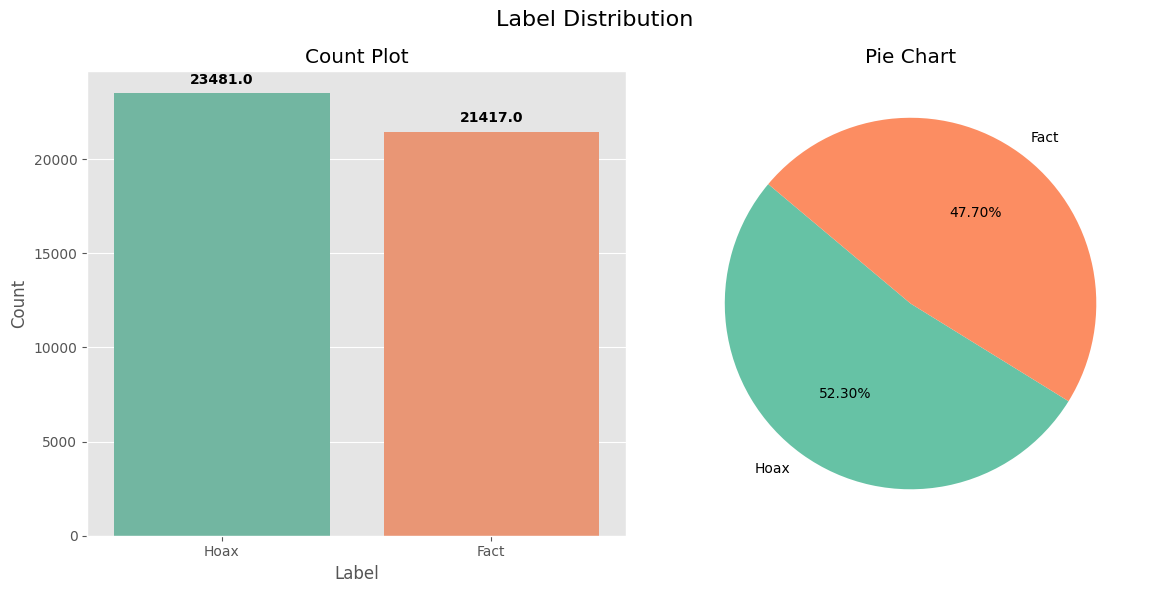

In [6]:
def label_dist(df, label):
    plt.figure(figsize=(12, 6))
    plt.suptitle('Label Distribution', fontsize=16)
    plt.subplot(1, 2, 1)
    ax = sns.countplot(data=df, x=label, palette='Set2')
    plt.title('Count Plot')
    plt.xlabel('Label')
    plt.ylabel('Count')
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10,fontweight='bold', color='black', xytext=(0, 5), textcoords='offset points')

    plt.subplot(1, 2, 2)
    df[label].value_counts().plot.pie(autopct='%.2f%%', colors=sns.color_palette('Set2'), startangle=140)
    plt.title('Pie Chart')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('label_distribution.png')
    plt.show()

label_dist(data, LABEL)

In [19]:
data['date'].str.split(' ').str[0].unique()

array(['December', 'November', 'October', 'September', 'August', 'July',
       'June', 'May', 'April', 'March', 'February', 'January',
       '19-Feb-18', '18-Feb-18', '17-Feb-18', '16-Feb-18', '15-Feb-18',
       '14-Feb-18', 'Dec', 'Nov',
       'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/',
       'Oct', 'Sep', 'Aug', 'Jul', 'Jun', 'Apr', 'Mar', 'Feb', 'Jan',
       'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/',
       'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/',
       'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg',
       'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg',
       'MSNBC'], dtype=object)

In [12]:
data[data['date'].str.contains('Feb')]

,title,text,subject,date,label,text_length
2356,Publisher Announces Books By The Obamas Are O...,Penguin Random House announced on Tuesday nigh...,News,"February 28, 2017",Hoax,2612
2357,WATCH: Keith Olbermann Goes On EPIC Pre-Trump...,Keith Olbermann rants on a very regular basis....,News,"February 28, 2017",Hoax,1813
2358,Trump Suggests White Anti-Semites NOT Attacki...,There s been a spate of attacks on Jews around...,News,"February 28, 2017",Hoax,2308
2359,The Vacationer-In-Chief Was Asked To Grade Hi...,Amateur president Donald Trump s first thirty ...,News,"February 28, 2017",Hoax,2888
2360,Jon Stewart Brilliantly Reveals Trump’s MAJOR...,Jon Stewart may not be routinely commenting on...,News,"February 28, 2017",Hoax,1772
...,...,...,...,...,...,...
34504,House Republicans to push Puerto Rico bill by ...,WASHINGTON (Reuters) - Republicans plan to bri...,politicsNews,"February 1, 2016",Fact,1400
34505,Obama to seek $755 million for cancer 'moonsho...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"February 1, 2016",Fact,1975
34506,The frequent-flyer U.S. Congress: lawmakers wo...,WASHINGTON (Reuters) - Anyone seeking a table ...,politicsNews,"February 1, 2016",Fact,7031
34507,Outside campaign groups lag U.S. presidential ...,"DES MOINES, Iowa (Reuters) - In 2015, it wasn’...",politicsNews,"February 1, 2016",Fact,1946


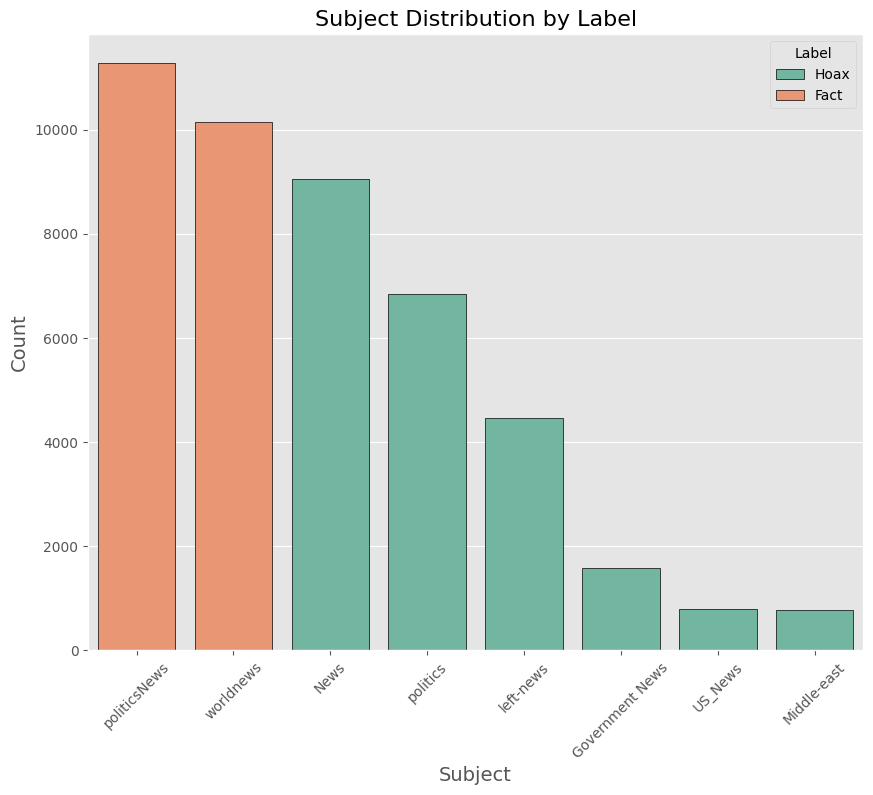

In [7]:
plt.figure(figsize=(10,8))
ax = sns.countplot(data=data, x='subject', hue='label', palette='Set2', edgecolor='black', order=data['subject'].value_counts().index)
plt.title('Subject Distribution by Label', fontsize=16)
plt.xlabel('Subject', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.savefig('subject_distribution.png')
plt.show()


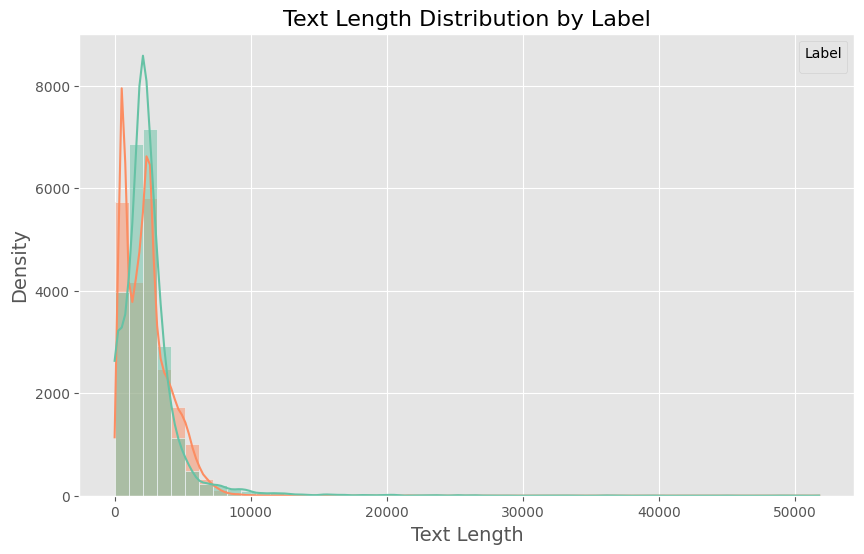

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.histplot(data=data, x='text_length', hue='label', bins=50, kde=True, palette='Set2')
plt.title('Text Length Distribution by Label', fontsize=16)
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Label')
plt.show()

## Cleaning

In [9]:
data.head()

,title,text,subject,date,label,text_length
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Hoax,2893
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Hoax,1898
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Hoax,3597
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Hoax,2774
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Hoax,2346


In [8]:
re.findall( "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", " ".join(data['text']))

['➡️', '☑️', '☑️', '☑️', 'ツ']

In [16]:
data[data['date'].str.contains('-')]['date'].unique()

array(['19-Feb-18', '18-Feb-18', '17-Feb-18', '16-Feb-18', '15-Feb-18',
       '14-Feb-18',
       'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/',
       'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/',
       'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/',
       'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg',
       'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg'],
      dtype=object)

In [65]:
text_fact = data[data['label'] =='Fact']['text']
sample = text_fact.sample(5)
print(sample)
sample.apply(lambda x: "".join(x.split("-")[1]) if '-' in x else x).str.strip()

34701    WASHINGTON (Reuters) - The White House on Frid...
26833    WASHINGTON (Reuters) - Two top U.S. intelligen...
27317    WASHINGTON (Reuters) - Senate Judiciary Commit...
36980    NAIROBI (Reuters) - The U.S. military did not ...
34539    WASHINGTON (Reuters) - U.S. presidential candi...
Name: text, dtype: object


34701    The White House on Friday said it will rely on...
26833    Two top U.S. intelligence officials told a Sen...
27317    Senate Judiciary Committee Chairman Chuck Gras...
36980    The U.S. military did not kill any civilians w...
34539    U.S. presidential candidate Donald Trump on We...
Name: text, dtype: object

In [8]:
data.loc[data['label'] == 'Fact', 'text'] = data.loc[data['label'] == 'Fact', 'text'].apply(lambda x: "".join(x.split("-")[1:]) if '-' in x else x).str.strip()

In [10]:
emoji_pattern = re.compile( "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
print("Total Emojis found in the dataset: ", len(emoji_pattern.findall(" ".join(data['text']))))

Total Emojis found in the dataset:  5


In [25]:
def demojize_emoji(text):
    emoji_pattern = re.compile(
        "["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE
       )
    
    # return emoji_pattern.sub(lambda x: re.sub(r'[\W_]', " ",emoji.demojize(x.group())), text).strip()

    if bool(emoji_pattern.search(text)):
        return re.sub("[\W_]"," ",emoji.demojize(text, delimiters=("", " ")))
    return text
    


text = "I love programming! 😍💻"

# example usage
demojized_text = demojize_emoji(text)
print("Original Text: ", text)
print("Demojized Text: ", demojized_text)


Original Text:  I love programming! 😍💻
Demojized Text:  I love programming  smiling face with heart eyes laptop 


In [26]:
def normalize_unicode(text):
    text = ftfy.fix_text(text)
    return "".join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

# example usage
weird_text = "Café 😊 is coöperation naïve fiancé jalapeño año."
normalized_text = normalize_unicode(weird_text)
print("Original Text: ", weird_text)
print("Normalized Text: ", normalized_text)

Original Text:  Café 😊 is coöperation naïve fiancé jalapeño año.
Normalized Text:  Cafe 😊 is cooperation naive fiance jalapeno ano.


In [43]:
def cleaned_text(text):

    text = text.lower()
    text = demojize_emoji(text)
    text = normalize_unicode(text)
    
    text = re.sub(r'(im)\s', 'i am ', text)
    text = re.sub(r"i[' ]m", "i am", text)
    text = re.sub(r"can[' ]t", "can not", text)
    text = re.sub(r"don[' ]t", "do not", text)
    text = re.sub(r"shouldn[' ]t", "should not", text)
    text = re.sub(r"needn[' ]t", "need not", text)
    text = re.sub(r"hasn[' ]t", "has not", text)
    text = re.sub(r"haven[' ]t", "have not", text)
    text = re.sub(r"weren[' ]t", "were not", text)
    text = re.sub(r"mightn[' ]t", "might not", text)
    text = re.sub(r"didn[' ]t", "did not", text)
    text = re.sub(r"it[' ]s ", "it is ", text)
    text = re.sub(r"(?:'| )re ", " are ", text)
    text = re.sub(r"(?:'| )s ", " is ", text)
    text = re.sub(r"(?:'| )d ", " would ", text)
    text = re.sub(r"(?:'| )ll ", " will ", text)
    text = re.sub(r"n(?:'| )t ", " not ", text)
    text = re.sub(r"(?:'| )ve ", " have ", text)
    text = re.sub(r"(?:'| )t ", " not ", text)
    text = re.sub("gonna|gon na", "going to", text)
    text = re.sub("wanna|wan na", "want to", text)
    text = re.sub("rn", "right now", text)
    text = re.sub("idk", 'i dont know', text)
    text = re.sub(r"http?://\S+|www\.\S+|https?://\S+", '', text)
    #text = re.sub('[^a-zA-Z0-9\s]', "", text)
    text = "".join([word for word in text if not word in string.punctuation])
    text = re.sub('[\n\t\r]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()

    return text
    

In [44]:
text = " i couldn't visit the café 😊 because I don't have time! Visit http://example.com "

cleaned = cleaned_text(text)
print("Original Text: ", text)
print("Cleaned Text: ", cleaned)

Original Text:   i couldn't visit the café 😊 because I don't have time! Visit http://example.com 
Cleaned Text:  i could not visit the cafe smiling face with smiling eyes because i do not have time visit http example com


In [28]:

print("Original Text:")
sample_text = data['text'].sample(5).tolist()
for i, text in enumerate(sample_text, 1):
    print(f"{i}: {text}")

print("\nCleaned Text:")
cleaned = [cleaned_text(text) for text in sample_text]
for i, text in enumerate(cleaned, 1):
    print(f"{i}: {text}")

Original Text:
1: The United States on Thursday presented for the first time pieces of what it said were Iranian weapons supplied to the Iranaligned Houthi militia in Yemen, describing it as conclusive evidence that Tehran was violating U.N. resolutions. The arms included charred remnants of what the Pentagon said was an Iranianmade shortrange ballistic missile fired from Yemen on Nov. 4 at King Khaled International Airport outside Saudi Arabia s capital Riyadh, as well as a drone and an antitank weapon recovered in Yemen by the Saudis. Iran has denied supplying the Houthis with such weaponry and on Thursday described the arms displayed as  fabricated.  The United States acknowledged it could not say precisely when the weapons were transferred to the Houthis, and, in some cases, could not say when they were used. There was no immediate way to independently verify where the weapons were made or employed. But U.S. Ambassador to the United Nations Nikki Haley expressed confidence the tran

In [29]:
data['cleaned_text'] = data['text'].apply(cleaned_text)

In [30]:
noise = data[(data['cleaned_text'] == ' ') | (data['cleaned_text'] == '')]
data.drop(noise.index, inplace=True)

In [31]:
noise = data[data['date'].str.contains('MSNBC')]
data.drop(noise.index, inplace=True)

In [32]:
data[data.duplicated(subset=['cleaned_text'])].head(20)

,title,text,subject,date,label,text_length,cleaned_text
9114,WHY THIS BLUE-COLLAR DEMOCRAT STRONGHOLD Count...,AP News The regulars amble in before dawn and...,politics,"Dec 27, 2017",Hoax,8241,ap news the regulars amble in before dawn and ...
9738,LEFTIST STORE OWNER Makes Video Asking Libs To...,Things didn t go as well as Nicholle had hoped...,politics,"Oct 6, 2017",Hoax,2792,things did not go as well as nicholle had hope...
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",Hoax,1933,no time to waste we have got to fight with eve...
10924,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",politics,"May 10, 2017",Hoax,10783,in its 109year history only one fbi director h...
11146,TWITTER Posts Hilarious Images After Announcem...,Here s the original post by the Washington Pos...,politics,"Apr 13, 2017",Hoax,931,here is the original post by the washington po...
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",Hoax,569,who is silencing political speech physically a...
11517,MULTI-MILLIONAIRE Global-Warming Hypocrites LE...,Enjoy:,politics,"Mar 2, 2017",Hoax,6,enjoy
11796,TRUMP’S BRILLIANT Director Of Communications O...,Watch:,politics,"Jan 28, 2017",Hoax,7,watch
12063,OUCH! Paul Joseph Watson DESTROYS MTV’s Racist...,Enjoy,politics,"Dec 26, 2016",Hoax,6,enjoy
12174,ARMY-NAVY CROWD ERUPTS During Trump Interview…...,Watch:,politics,"Dec 10, 2016",Hoax,6,watch


In [33]:
print(f"Total Data before removing duplicates: {data.shape[0]}")
data.drop_duplicates(subset=['cleaned_text'], inplace=True)
print(f"Total Data after removing duplicates: {data.shape[0]}")

Total Data before removing duplicates: 44182
Total Data after removing duplicates: 38351


In [34]:
def cleaned_date(x):
    mapping = {
        'Jan': 'January', 'Feb': 'February', 'Mar': 'March',
        'Apr': 'April', 'May': 'May', 'Jun': 'June',
        'Jul': 'July', 'Aug': 'August', 'Sep': 'September',
        'Oct': 'October', 'Nov': 'November', 'Dec': 'December'
    }

    if "-" in x:  # contoh: 19-Feb-18
        day, month, year = x.split('-')
        month = mapping.get(month, month)
        if len(year) == 2:
            year = "20" + year
        return f"{month} {day}, {year}"
    else:
        month = x.split(' ')[0]
        return x.replace(month, mapping.get(month, month))


    
def encode_month(x):
    months = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }
    
    month = x.split(' ')[0]
    return x.replace(month, str(months[month]))

date = 'February 19, 2018'
date = cleaned_date(date)
date = encode_month(date)
pd.to_datetime(date)
    


Timestamp('2018-02-19 00:00:00')

In [35]:

data['cleaned_date'] = data['date'].apply(cleaned_date)
for _, row in data.iterrows():
    try:
        data.at[_, 'cleaned_date'] = pd.to_datetime(row['cleaned_date'])
    except Exception as e:
        print(row['cleaned_date'])

In [36]:
data['cleaned_date'] = pd.to_datetime(data['cleaned_date'])

In [37]:
summary(data)

Shape: (38351, 8)

List Features: 
1. title
2. text
3. subject
4. date
5. label
6. text_length
7. cleaned_text
8. cleaned_date

Summary: 


,Dtype,#Missing,%Missing,Nunique
title,object,0,0.0,38208
text,object,0,0.0,38351
subject,object,0,0.0,7
date,object,0,0.0,2390
label,object,0,0.0,2
text_length,int64,0,0.0,6724
cleaned_text,object,0,0.0,38351
cleaned_date,datetime64[ns],0,0.0,1010



Sampel Data: 
1. Hoax:
7922     Newly unearthed video shows Bernie Sanders giv...
5724     Cracks are beginning to form in the GOP s wall...
7222     Donald Trump s campaign manager Corey Lewandow...
7732     They whined and fear mongered, but in the end,...
21596    Wow just wow!A pregnant woman has challenged p...
Name: text, dtype: object

2. Fact:
37740    Northern Ireland s main political parties poin...
26262    Senate Judiciary Committee Chairman Charles Gr...
24175    U.S. President Donald Trump would want Republi...
37869    Lawmakers from President Robert Mugabe s rulin...
42237    Russian and North Korean officials will meet i...
Name: text, dtype: object



In [38]:
def extract_date_features(df, feature):
    df['year'] = df[feature].dt.year
    df['month'] = df[feature].dt.month
    df['day'] = df[feature].dt.day
    df['dayofweek'] = df[feature].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    df['weekofyear'] = df[feature].dt.isocalendar().week
    df['quarter'] = df[feature].dt.quarter
    return df

data = extract_date_features(data, 'cleaned_date')
data

,title,text,subject,date,label,text_length,cleaned_text,cleaned_date,year,month,day,dayofweek,is_weekend,weekofyear,quarter
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Hoax,2893,donald trump just could not wish all americans...,2017-12-31,2017,12,31,6,1,52,4
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Hoax,1898,house intelligence committee chairman devin nu...,2017-12-31,2017,12,31,6,1,52,4
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Hoax,3597,on friday it was revealed that former milwauke...,2017-12-30,2017,12,30,5,1,52,4
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Hoax,2774,on christmas day donald trump announced that h...,2017-12-29,2017,12,29,4,0,52,4
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Hoax,2346,pope francis used his annual christmas day mes...,2017-12-25,2017,12,25,0,0,52,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44892,North Korea shipments to Syria chemical arms a...,Two North Korean shipments to a Syrian governm...,worldnews,"August 21, 2017",Fact,2906,two north korean shipments to a syrian goverig...,2017-08-21,2017,8,21,0,0,34,3
44894,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an...",worldnews,"August 22, 2017",Fact,800,lexisnexis a provider of legal regulatory and ...,2017-08-22,2017,8,22,1,0,34,3
44895,Minsk cultural hub becomes haven from authorities,In the shadow of disused Sovietera factories i...,worldnews,"August 22, 2017",Fact,1950,in the shadow of disused sovietera factories i...,2017-08-22,2017,8,22,1,0,34,3
44896,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...,worldnews,"August 22, 2017",Fact,1199,vatican secretary of state cardinal pietro par...,2017-08-22,2017,8,22,1,0,34,3


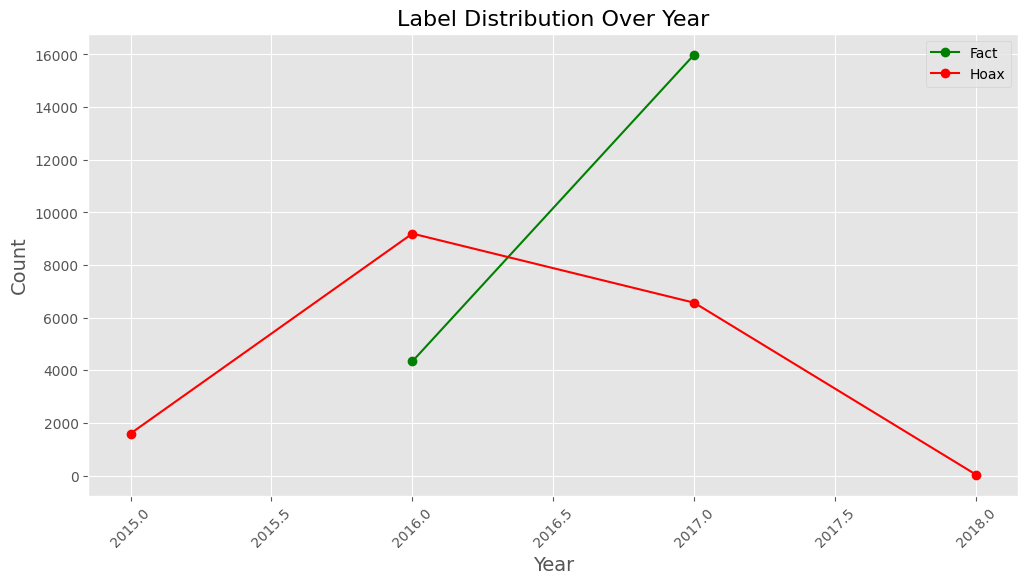

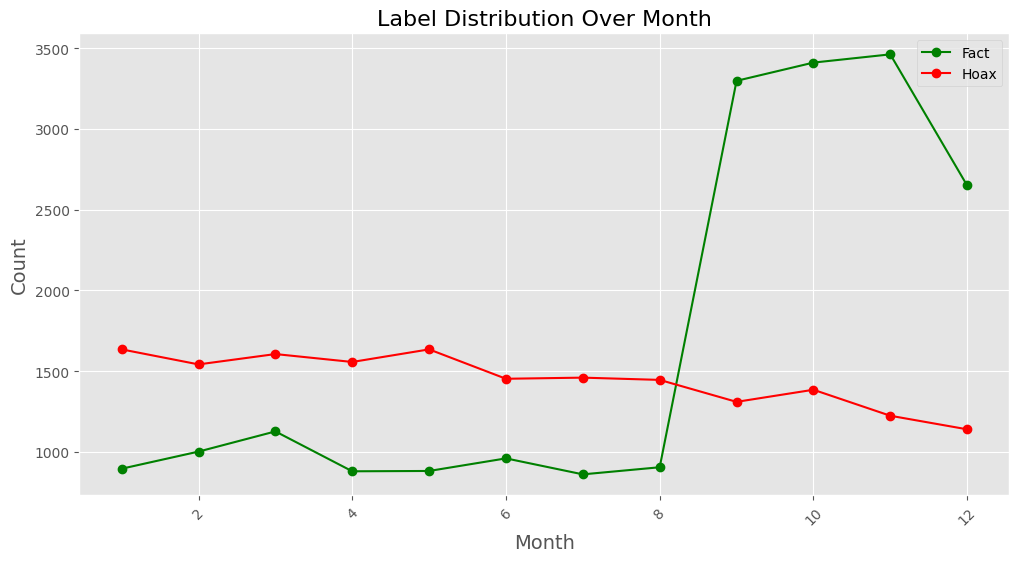

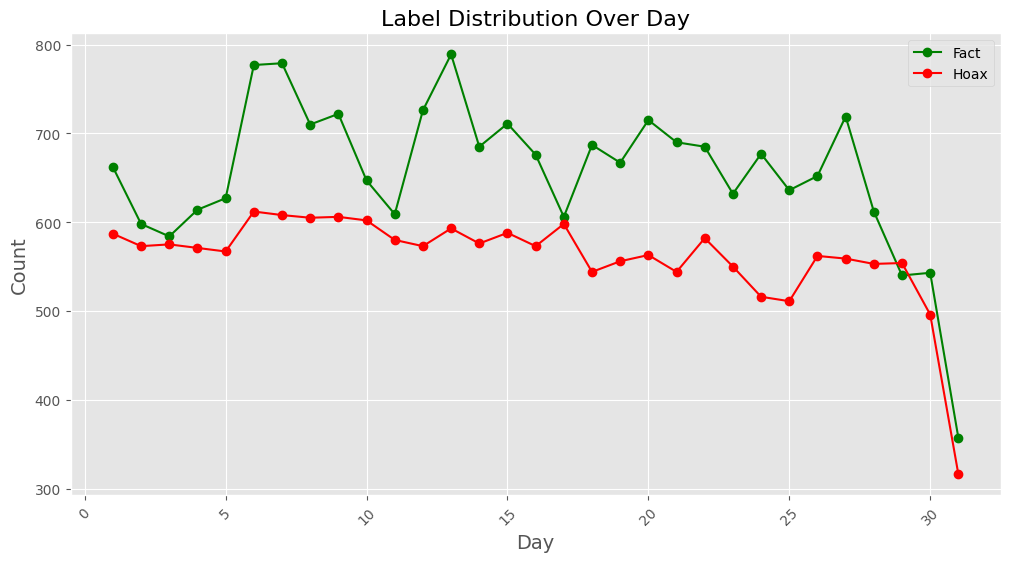

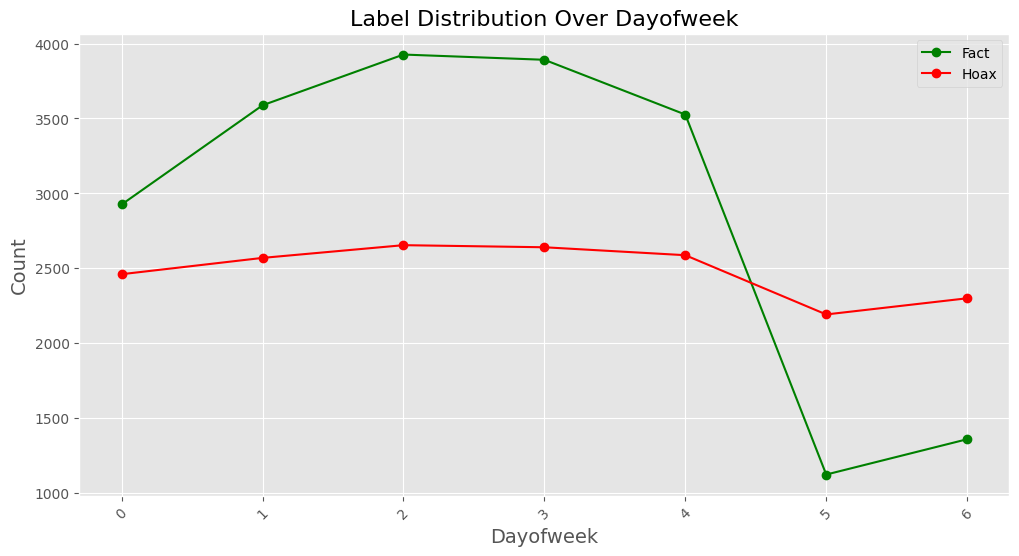

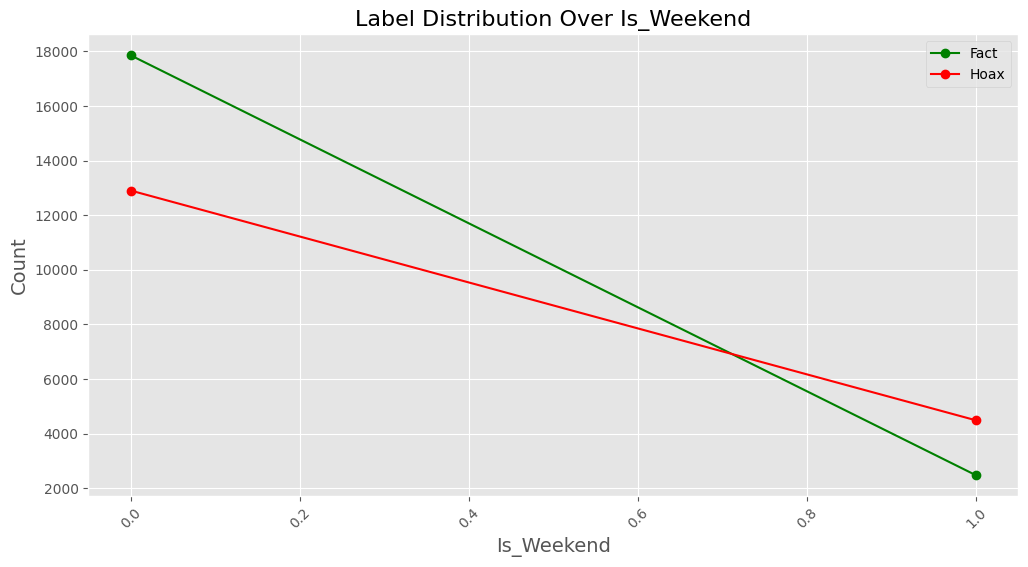

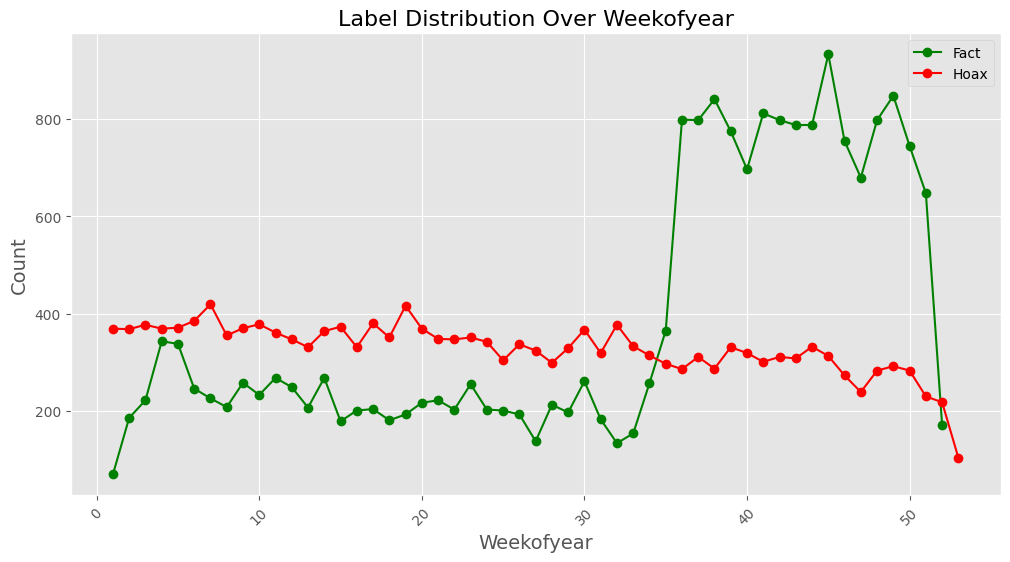

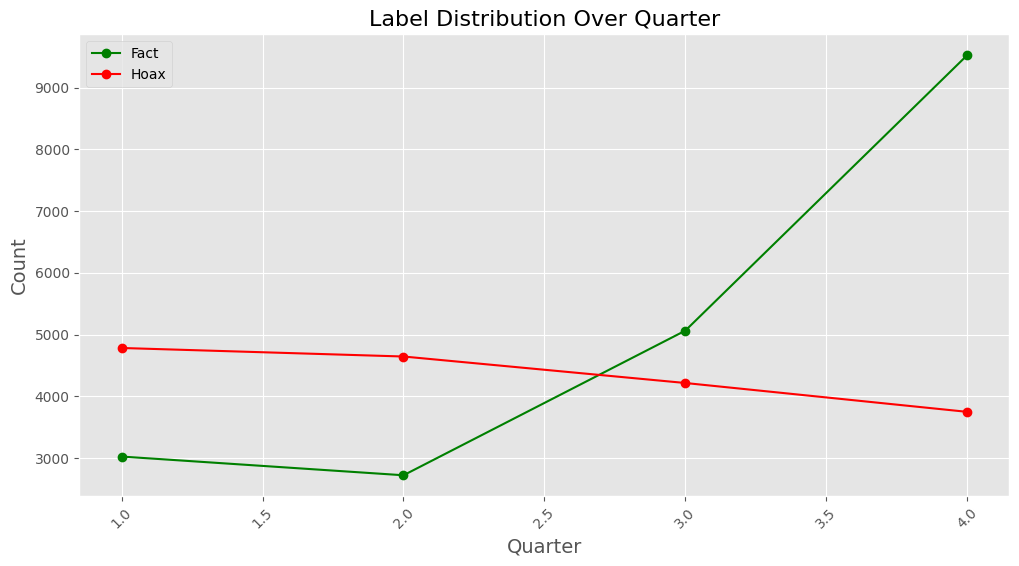

In [18]:
# label distribution monthly

data = data.sort_values(by='cleaned_date')
for col in ['year', 'month', 'day', 'dayofweek', 'is_weekend', 'weekofyear', 'quarter']:
    plt.figure(figsize=(12,6))
    fact = data[data['label'] == 'Fact'].groupby(col).size()
    hoax = data[data['label'] == 'Hoax'].groupby(col).size()
    plt.plot(fact.index, fact.values, marker='o', label='Fact', color='green')
    plt.plot(hoax.index, hoax.values, marker='o', label='Hoax', color='red')
    plt.title(f'Label Distribution Over {col.title()}', fontsize=16)
    plt.xlabel(col.title(), fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'label_distribution_over_{col}.png')
    plt.show()


In [39]:
data['title'] = data['title'].apply(cleaned_text)
text_cols = ['title','cleaned_text']

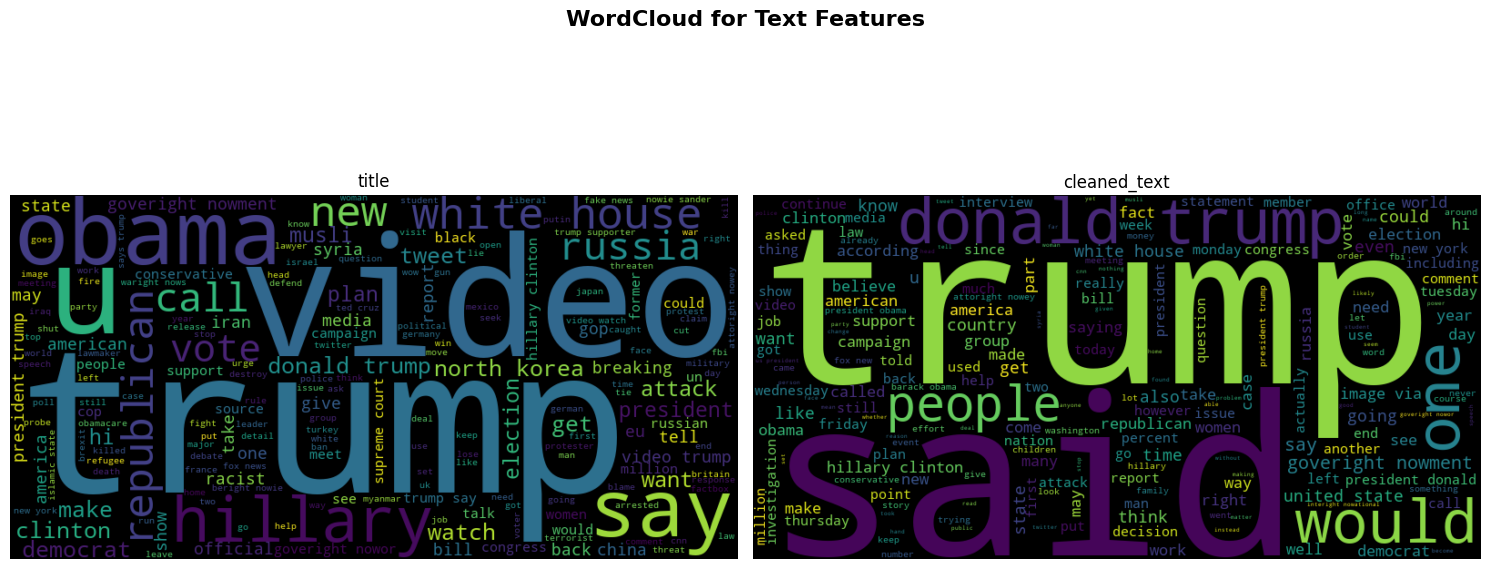

In [ ]:
def wordcloud_plot(df, features):
    STOPWORDS = set(stopwords.words('english'))
    length = len(features)
    cols = 2
    rows = length // cols + (length % cols > 0)
    plt.figure(figsize=(15, 7 * rows))
    plt.suptitle('WordCloud for Text Features', fontsize=16, fontweight='bold')
    for i, feature in enumerate(features, 1):
        plt.subplot(rows, cols, i)
        full = " ".join(text for text in df[feature])
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='black',
            colormap='viridis',
            contour_width=3,
            contour_color='steelblue',
            stopwords=STOPWORDS
        ).generate(full)

        plt.imshow(wordcloud)
        plt.axis('off')
        plt.title(f'{feature}', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

wordcloud_plot(data, text_cols)

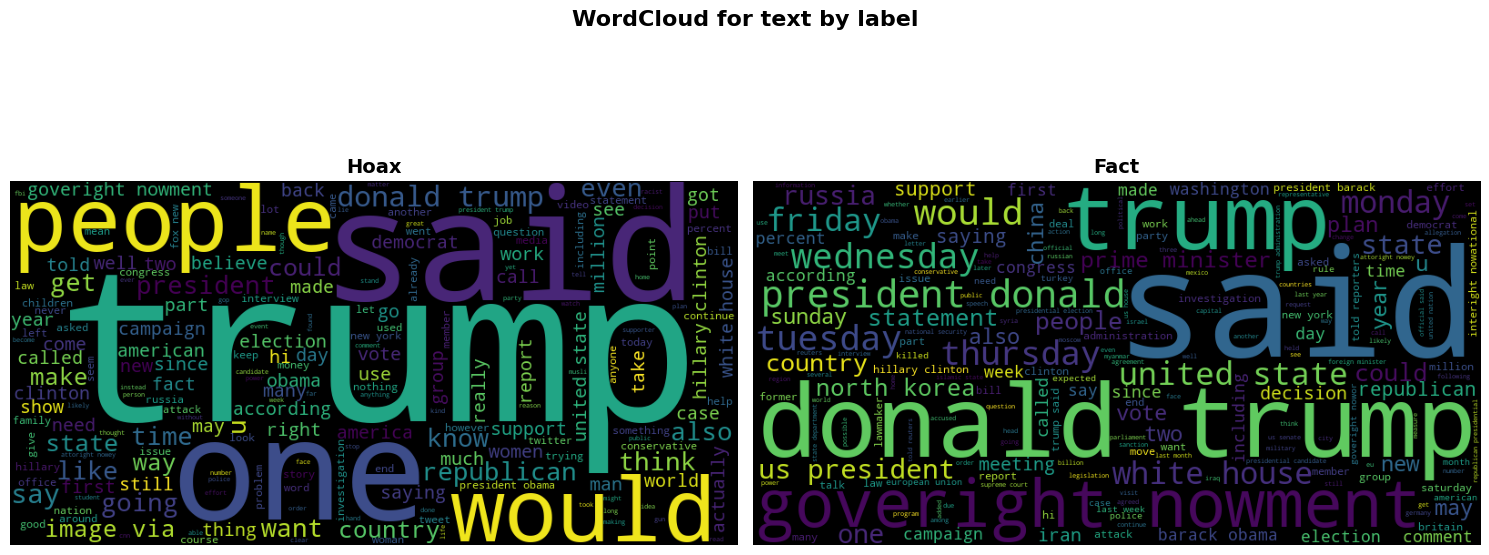

In [22]:
def wordcloud_label(df, label_col, col):
    uniq = df[label_col].unique()
    length = len(uniq)
    cols = 2
    rows = length // cols + (length % cols > 0)
    plt.figure(figsize=(15, 7 * rows))
    plt.suptitle(f'WordCloud for text by {label_col}', fontsize=16, fontweight='bold')
    for i, label in enumerate(uniq, 1):
        plt.subplot(rows, cols, i)
        subset = df[df[label_col] == label]
        full = " ".join(text for text in subset[col])
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='black',
            colormap='viridis',
            contour_width=3,
            contour_color='steelblue',
            stopwords=set(stopwords.words('english'))
        ).generate(full)

        plt.imshow(wordcloud)
        plt.axis('off')
        plt.title(f'{label}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'wordcloud_{col}_by_{label_col}.png')
    plt.show()
wordcloud_label(data, 'label', 'cleaned_text')

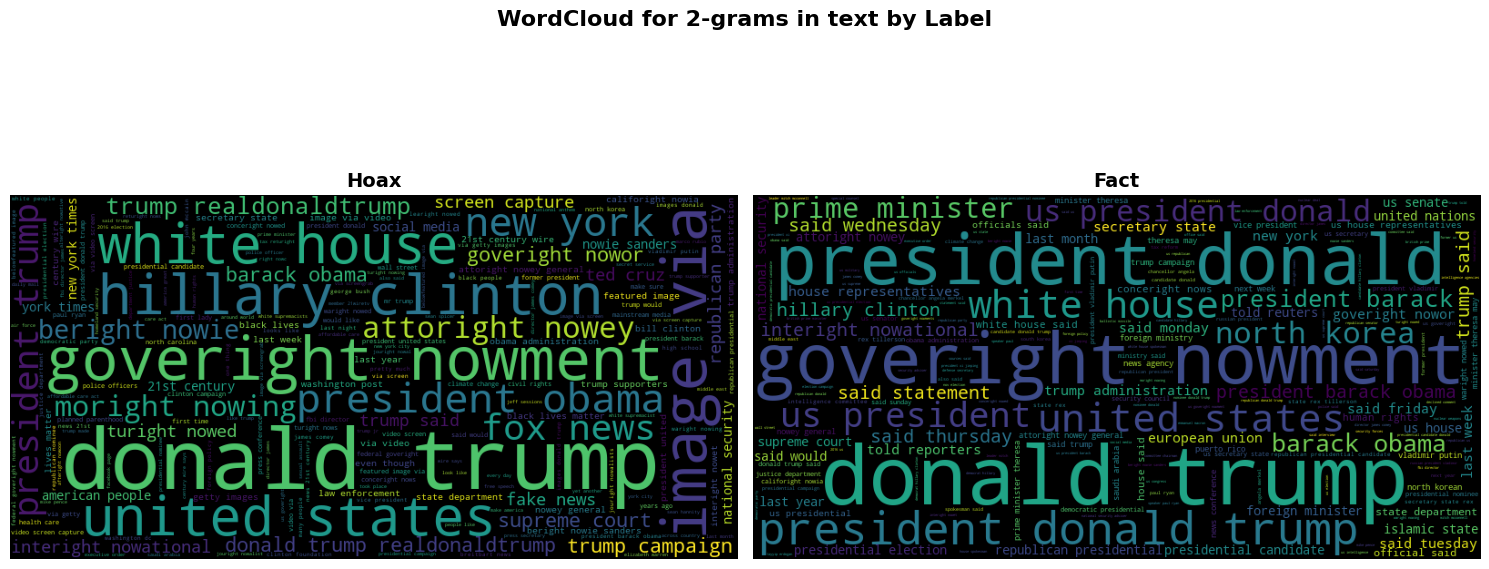

In [20]:
def wordcloud_plot_ngram(df, feature, n=2):
    STOPWORDS = set(stopwords.words('english'))
    uniq = df['label'].unique()
    length = len(uniq)
    cols = 2
    rows = length // cols + (length % cols > 0)

    plt.figure(figsize=(15, 7 * rows))
    plt.suptitle(f'WordCloud for {n}-grams in text by Label', fontsize=16, fontweight='bold')
    for i, label in enumerate(uniq, 1):
        plt.subplot(rows, cols, i)
        subset = df[df['label'] == label]
        full = ' '.join(text for text in subset[feature])
        vectorizer = CountVectorizer(ngram_range=(n, n+1), stop_words=list(STOPWORDS))
        X = vectorizer.fit_transform([full])
        ngram_freq = X.toarray().sum(axis=0)
        ngram_dict = dict(zip(vectorizer.get_feature_names_out(), ngram_freq))

        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='black',
            colormap='viridis',
            contour_width=3,
            contour_color='steelblue'
        ).generate_from_frequencies(ngram_dict)

        plt.imshow(wordcloud)
        plt.axis('off')
        plt.title(f'{label}', fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'wordcloud_{n}gram.png')
    plt.show()

wordcloud_plot_ngram(data, 'cleaned_text', n=2)

1: Hoax - 5590590 words


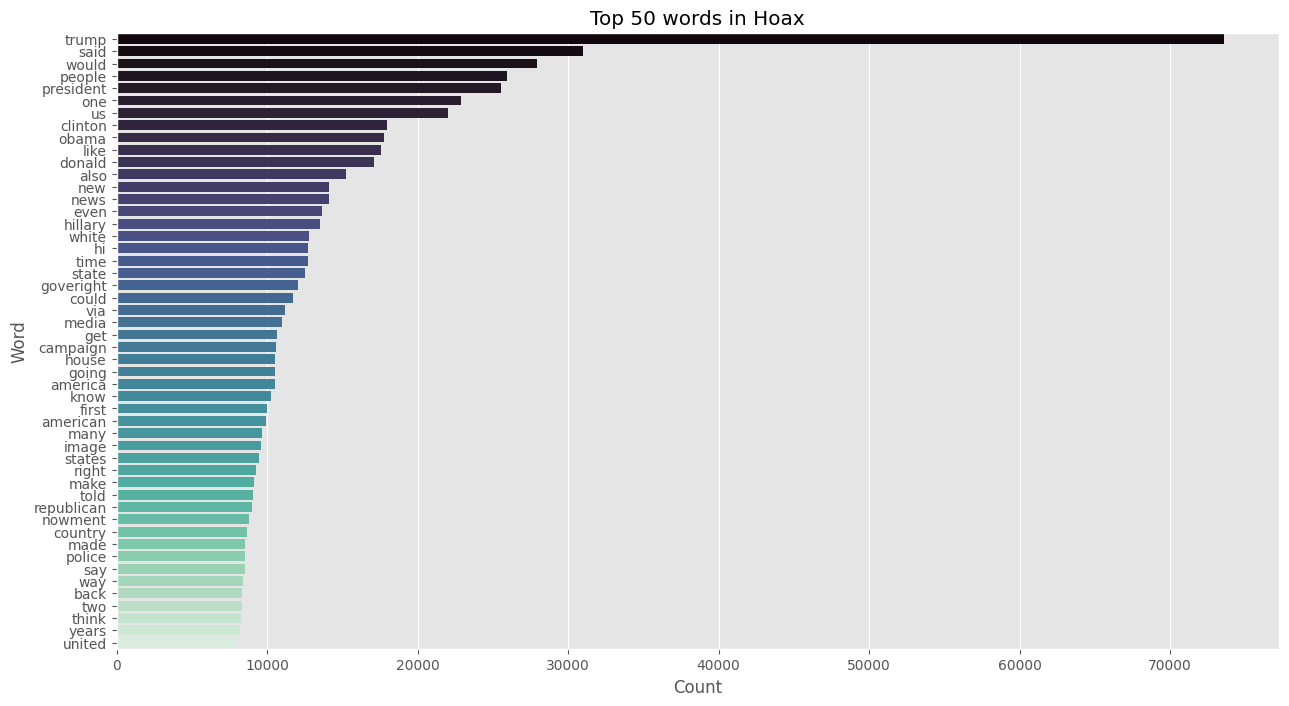

2: Fact - 1189265 words


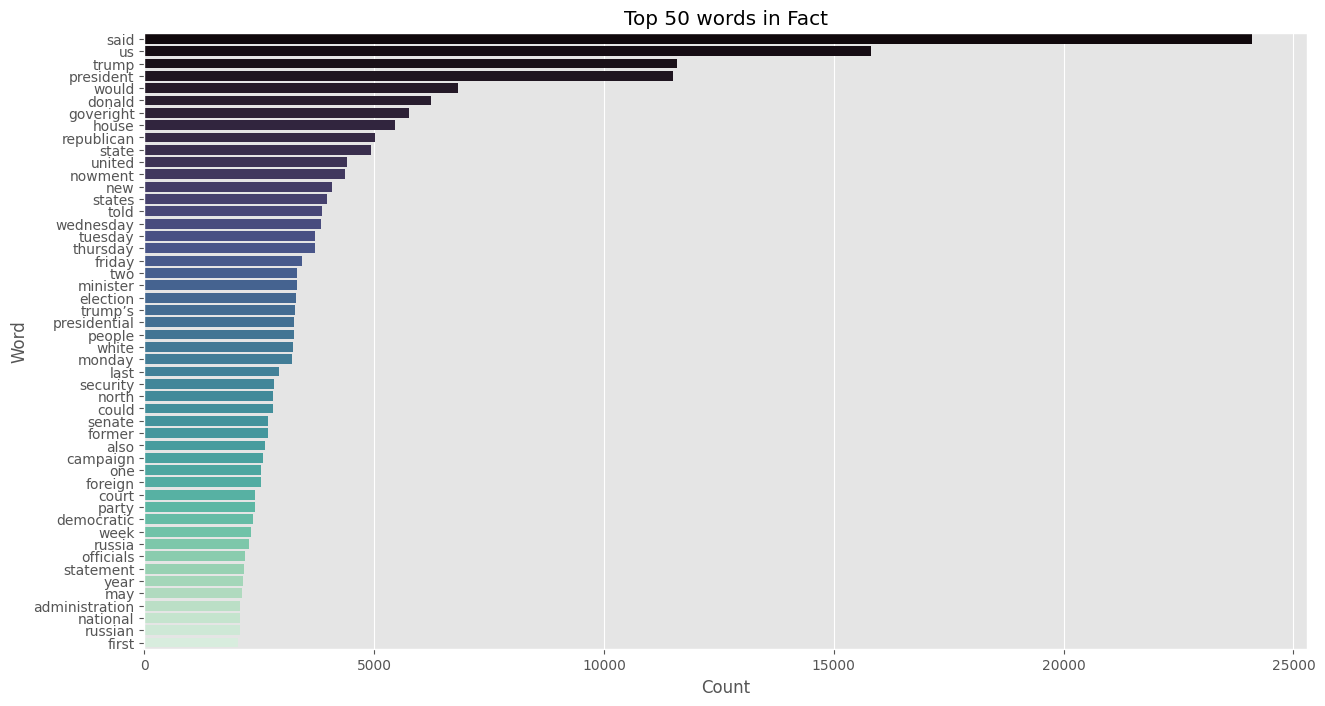

In [70]:
def make_corpus(df, label):
    STOPWORDS = set(stopwords.words('english'))
    corpus = []
    for text in df.loc[df[LABEL] == label, "cleaned_text"].str.split():
        for word in text:
            if word not in STOPWORDS:
                corpus.append(word)
    return corpus

for i,label in enumerate(data[LABEL].unique(), 1):
    print(f"{i}: {label} - {len(make_corpus(data, label))} words")
    counter = Counter(make_corpus(data, label))
    mc = counter.most_common()

    w,c = [], []
    for word, count in mc[:50]:
        w.append(word)
        c.append(count)

    plt.figure(figsize=(15, 8))
    sns.barplot(x = c, y = w, palette='mako')
    plt.title(f"Top 50 words in {label}")
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

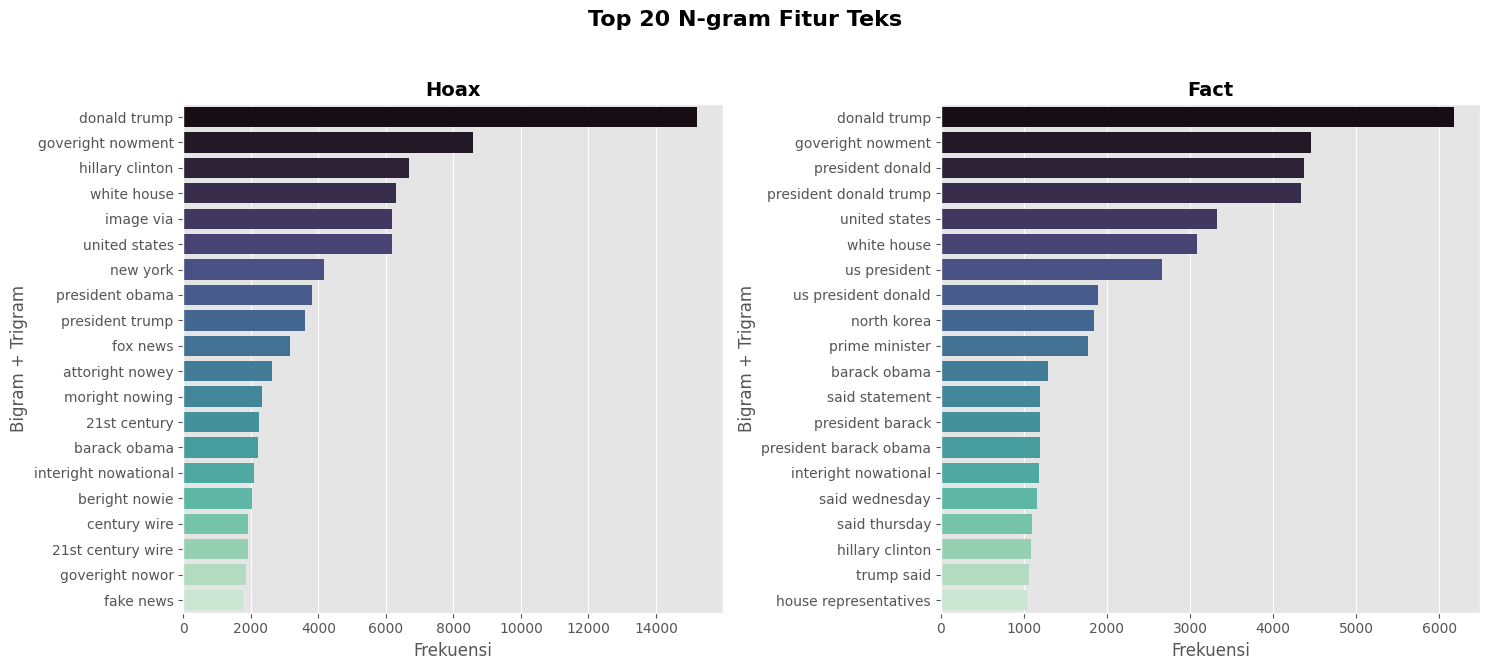

In [72]:
def make_corpus(df, label):
    STOPWORDS = set(stopwords.words('english'))
    corpus = []
    for text in df.loc[df[LABEL] == label, "cleaned_text"].str.split():
        for word in text:
            if word not in STOPWORDS:
                corpus.append(word)
    return corpus

def get_top_ngrams(corpus, n=2, top_k=20):
    vectorizer = CountVectorizer(ngram_range=(n, n+1))
    X = vectorizer.fit_transform([" ".join(corpus)])
    ngram_freq = X.toarray().sum(axis=0)
    ngram_dict = dict(zip(vectorizer.get_feature_names_out(), ngram_freq))
    top_ngrams = Counter(ngram_dict).most_common(top_k)
    return top_ngrams

uniq = data[LABEL].unique()
length = len(uniq)
cols = 2
rows = length // cols + (length % cols > 0)
plt.figure(figsize=(15, 7 * rows))
plt.suptitle('Top 20 N-gram Fitur Teks', fontsize=16, fontweight='bold')
for i, label in enumerate(uniq, 1):
    corpus = make_corpus(data, label)
    top_bigrams = get_top_ngrams(corpus, n=2, top_k=20)

    bigrams, freqs = zip(*top_bigrams)
    plt.subplot(rows, cols, i)
    sns.barplot(x=list(freqs), y=list(bigrams), palette='mako')
    plt.title(f'{label}', fontsize=14, fontweight='bold')
    plt.xlabel('Frekuensi')
    plt.ylabel('Bigram + Trigram')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [40]:
features = ['text', 'cleaned_text', LABEL]
data_final = data.copy()
data_final = data_final[features]
data_final.head()

,text,cleaned_text,label
0,Donald Trump just couldn t wish all Americans ...,donald trump just could not wish all americans...,Hoax
1,House Intelligence Committee Chairman Devin Nu...,house intelligence committee chairman devin nu...,Hoax
2,"On Friday, it was revealed that former Milwauk...",on friday it was revealed that former milwauke...,Hoax
3,"On Christmas day, Donald Trump announced that ...",on christmas day donald trump announced that h...,Hoax
4,Pope Francis used his annual Christmas Day mes...,pope francis used his annual christmas day mes...,Hoax


In [ ]:
def add_features(df):
    df['word_count'] = df['text'].apply(lambda x: len(word_tokenize(x)))
    df['sentence_count'] = df['text'].apply(lambda x: len(sent_tokenize(x)))
    df['lexical_diversity'] = df['text'].apply(lambda x: len(set(word_tokenize(x)))) / df['word_count']
    df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    return df

data_final = add_features(data_final)
data_final.head()

,text,cleaned_text,label,word_count,sentence_count,lexical_diversity,polarity,subjectivity
0,Donald Trump just couldn t wish all Americans ...,donald trump just could not wish all americans...,Hoax,599,28,0.435726,0.082132,0.599895
1,House Intelligence Committee Chairman Devin Nu...,house intelligence committee chairman devin nu...,Hoax,331,11,0.595166,-0.005004,0.334098
2,"On Friday, it was revealed that former Milwauk...",on friday it was revealed that former milwauke...,Hoax,689,25,0.480406,-0.012345,0.541969
3,"On Christmas day, Donald Trump announced that ...",on christmas day donald trump announced that h...,Hoax,519,15,0.502890,-0.023118,0.394086
4,Pope Francis used his annual Christmas Day mes...,pope francis used his annual christmas day mes...,Hoax,458,19,0.504367,-0.011722,0.495222


In [37]:
cols = ['word_count', 'sentence_count', 'lexical_diversity', 'polarity', 'subjectivity']
for col in cols:
    group = data_final.groupby(LABEL)[col].mean()
    print(f"Feature: {col}")
    print(group)
    print("-"*50)

Feature: word_count
label
Fact    428.364546
Hoax    474.846375
Name: word_count, dtype: float64
--------------------------------------------------
Feature: sentence_count
label
Fact    14.778082
Hoax    15.436382
Name: sentence_count, dtype: float64
--------------------------------------------------
Feature: lexical_diversity
label
Fact    0.565044
Hoax    0.562337
Name: lexical_diversity, dtype: float64
--------------------------------------------------
Feature: polarity
label
Fact    0.053168
Hoax    0.061350
Name: polarity, dtype: float64
--------------------------------------------------
Feature: subjectivity
label
Fact    0.361689
Hoax    0.453955
Name: subjectivity, dtype: float64
--------------------------------------------------


In [38]:
def ttest_(df, col, label):
    from scipy.stats import ttest_ind
    group1 = df[df[label] == df[label].unique()[0]][col]
    group2 = df[df[label] == df[label].unique()[1]][col]
    t_stat, p_value = ttest_ind(group1, group2)
    print(f"T-test for {col}:")
    print(f" - T-statistic: {t_stat:.4f}")
    print(f" - P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(" - Result: Significant difference between groups")
    else:
        print(" - Result: No significant difference between groups")
    print("-"*50)

for col in cols:    
    ttest_(data_final, col, LABEL)

T-test for word_count:
 - T-statistic: 12.8034
 - P-value: 0.0000
 - Result: Significant difference between groups
--------------------------------------------------
T-test for sentence_count:
 - T-statistic: 5.3688
 - P-value: 0.0000
 - Result: Significant difference between groups
--------------------------------------------------
T-test for lexical_diversity:
 - T-statistic: -2.3758
 - P-value: 0.0175
 - Result: Significant difference between groups
--------------------------------------------------
T-test for polarity:
 - T-statistic: 7.5891
 - P-value: 0.0000
 - Result: Significant difference between groups
--------------------------------------------------
T-test for subjectivity:
 - T-statistic: 78.2562
 - P-value: 0.0000
 - Result: Significant difference between groups
--------------------------------------------------


In [42]:
def preprocess(df, col='cleaned_text'):
    STOPWORDS= set(stopwords.words('english'))
    Lemma = WordNetLemmatizer()
    df[col] = df[col].apply(lambda x: " ".join([Lemma.lemmatize(word) for word in x.split() if word not in STOPWORDS]))
    return df

data_final_preprocessed = preprocess(data_final, 'cleaned_text')
data_final_preprocessed.head()

,text,cleaned_text,label,word_count,sentence_count,lexical_diversity,polarity,subjectivity
0,Donald Trump just couldn t wish all Americans ...,donald trump could wish american happy new yea...,Hoax,599,28,0.435726,0.082132,0.599895
1,House Intelligence Committee Chairman Devin Nu...,house intelligence committee chairman devin nu...,Hoax,331,11,0.595166,-0.005004,0.334098
2,"On Friday, it was revealed that former Milwauk...",friday revealed former milwaukee sheriff david...,Hoax,689,25,0.480406,-0.012345,0.541969
3,"On Christmas day, Donald Trump announced that ...",christmas day donald trump announced would bac...,Hoax,519,15,0.502890,-0.023118,0.394086
4,Pope Francis used his annual Christmas Day mes...,pope francis used annual christmas day message...,Hoax,458,19,0.504367,-0.011722,0.495222


In [45]:
data_final_preprocessed[(data_final_preprocessed['cleaned_text'].isna()) | (data_final_preprocessed['cleaned_text'] == '')]

,text,cleaned_text,label,word_count,sentence_count,lexical_diversity,polarity,subjectivity
15449,I VE HAD IT!,,Hoax,5,1,1.0,0.0,0.0


In [46]:
noise = data_final_preprocessed[(data_final_preprocessed['cleaned_text'].isna()) | (data_final_preprocessed['cleaned_text'] == '')]
data_final_preprocessed.drop(noise.index, inplace=True)

In [47]:
data_final_preprocessed['label'].replace({'Fact': 0, 'Hoax': 1}, inplace=True)
data_final_preprocessed.to_csv('../data/data_final.csv', index=False)

In [96]:
data_final_preprocessed = pd.read_csv('../data/data_final.csv')
